In [1]:
from glob import glob
from time import time
from datetime import datetime

import dgl
import numpy as np
import torch
from dgl.dataloading import GraphDataLoader, DataLoader
from model.GraphTransformer import GraphTransformer

from model.model import PredictionScore, PredictionPKD
from model.EGNN import EGNNNet
from model.complex_model import GatedGCNLSPENet, EGNNNet

from model.scheduler import CosineAnnealingWarmUpRestarts
from utils import *

from train.train import run_train_epoch, run_eval_epoch, run_eval_docking
from train.early_stop import EarlyStopping

from data.data import PDBbindDataset
from data.data_docking import PDBbindDataset_docking

In [2]:
TORCH = format_pytorch_version(torch.__version__)
CUDA = format_cuda_version(torch.version.cuda)
DGL = format_dgl_version(dgl.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[ INFO ] DEVICE: {device}, CUDA version: {CUDA}, TORCH version: {TORCH}, DGL version: {DGL}\n")
set_random_seed(0)

[ INFO ] DEVICE: cuda, CUDA version: cu117, TORCH version: 2.0.1, DGL version: 1.1.0+cu117

RANDOM, DGL, NUMPY and TORCH random seed is set 0.


In [4]:
cmodel = GatedGCNLSPENet(57, 256, 13, 25, 20, 4) #input_size, embedding_size, edge_size, com_edge_size, pose_size, num_layers, dropout_ratio=0.2
model = PredictionPKD(cmodel, 256).to(device)

In [20]:
# train = PDBbindDataset('./data/train_protein.graph', './data/train_ligand.graph', './data/train_complex.graph')
test  = PDBbindDataset('./data/test_protein.graph',  './data/test_ligand.graph',  './data/test_complex.graph' )
batch_size = 32
# train_loader = GraphDataLoader(train, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True)
test_loader  = GraphDataLoader(test,  batch_size=285, shuffle=False, drop_last=False, pin_memory=True)

In [7]:
# dt = datetime.now()
# # save_path = f'./save/native/early_stop_{dt.date()}_{dt.hour:02d}-{dt.minute:02d}-{dt.second:02d}.pth'

# # stopper = EarlyStopping( patience=50, mode="lower", metric="RMSE", filename=save_path )
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# # scheduler = CosineAnnealingWarmUpRestarts( optimizer, T_0=30, T_mult=1, eta_max=0.001, T_up=50, gamma=0.9 )
# # total_epoch = 5000

best_loss_epoch, best_loss = 0, 10000
best_corr_epoch, best_corr = 0, -1

LOSS = {"train": [], "test": [], "MDN": [], "pKd":[] }
# CORR = {"train": [], "val": [], "test": []}

TIME = 0
for epoch in range(1, total_epoch + 1):
    start = time()
    print("-" * 100)

    lr = optimizer.param_groups[0]["lr"]

    # train_loss, train_mdn_loss, train_rotate_loss = run_train_epoch(model, train_loader, optimizer, scheduler=scheduler, device=device)
    # test_loss, mdn_loss, pkd_loss, true, mdn, pkd = run_eval_epoch(model, test_loader, device=device)
    
    train_loss = run_train_epoch(model, train_loader, optimizer, scheduler, device=device)
    test_loss, true, pkd  = run_eval_epoch(model, test_loader, device=device)
    
    if best_loss > test_loss:
        best_loss_epoch = epoch
        best_loss = test_loss

    TIME = time() - start
    early_stop = stopper.step(test_loss, model)
    print(f"[ INFO ] Epoch: {epoch:03d}, Lr: {lr:.7f}, Time: {TIME:.2f}      <BEST> loss: {best_loss:.3f}, {best_loss_epoch:03d}")
    # print(f"\t<Loss> train: {train_loss:.3f}, // test: {test_loss:.3f}, mdn: {mdn_loss:.3f}, pkd: {pkd_loss:.3f}")
    print(f"\t<Loss> train: {train_loss:.3f}, // test: {test_loss:.3f},")
    print(f'TEST Corr: {torch.corrcoef( torch.stack( [pkd, true]  ))[1][0]:.3f}')

    if early_stop:
        end_time = datetime.now()
        print(f"Finish, time usage: {end_time - dt}, total epoch: {epoch}")
        
        model.load_state_dict(torch.load(save_path)['model_state_dict'])
        train_loss, train_true, train_pkd  = run_eval_epoch(model, train_loader, device=device)
        test_loss, true, pkd  = run_eval_epoch(model, test_loader, device=device)
        
        break

----------------------------------------------------------------------------------------------------


/home/sim/anaconda3/envs/PLBA/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


KeyboardInterrupt: 

In [3]:
cmodel = GatedGCNLSPENet(57, 256, 13, 25, 20, 4) #input_size, embedding_size, edge_size, com_edge_size, pose_size, num_layers, dropout_ratio=0.2
model = PredictionPKD(cmodel, 256).to(device)
model.load_state_dict(torch.load('./save/native/early_stop_2023-05-09_14-31-13.pth')['model_state_dict'])

<All keys matched successfully>

In [6]:
from collections import defaultdict

In [7]:
gps = defaultdict(list)
gls = defaultdict(list)
gcs = defaultdict(list)

for f in glob( '/data/PLBA/docking-power_graph/*/*' ):
    ppdb = f.split('/')[-2]
    if 'protein' in f:
        gps[ppdb].append(f)
    elif 'ligand' in f:
        gls[ppdb].append(f)
    elif 'complex' in f:
        gcs[ppdb].append(f)
    else:
        pass

In [34]:
for ppdb in gps:
    gp_paths = sorted( gps[ppdb] )
    gl_paths = sorted( gls[ppdb] )
    gc_paths = sorted( gcs[ppdb] )
    
    dataset = PDBbindDataset_docking( gp_paths, gl_paths, gc_paths )
    loader  = GraphDataLoader(dataset,  batch_size=285, shuffle=False, drop_last=False)
    pkd  = run_eval_docking(model, loader, device=device)
    
    
    write_f = open(f'/data/CASF-2016/power_docking/examples/PLBA/{ppdb}_score.dat', 'w')
    write_f.write('#code        score\n')
    for idx, value in enumerate(pkd):
        write_f.write(f'{gp_paths[idx][49:-4]}\t{value}\n')
    write_f.write( f'{ppdb}_ligand\t{native[ppdb]}' )
    write_f.close()

In [27]:
test_loss, true, pkd  = run_eval_epoch(model, test_loader, device=device)

In [28]:
pdbs = [ pdb[:-1] for pdb in open('/data/PLBA/PDB-coresets').readlines() ]

In [30]:
native = {}
for idx, pred in enumerate(pkd):
    native[pdbs[idx]]=  float(pred)

In [26]:
w = open( './PLBA.dat', 'w' )
w.write('#code  score\n')
for idx, pred in enumerate(pkd):
    w.write( f'{pdbs[idx]} {float(pred):.2f}\n')
w.close()

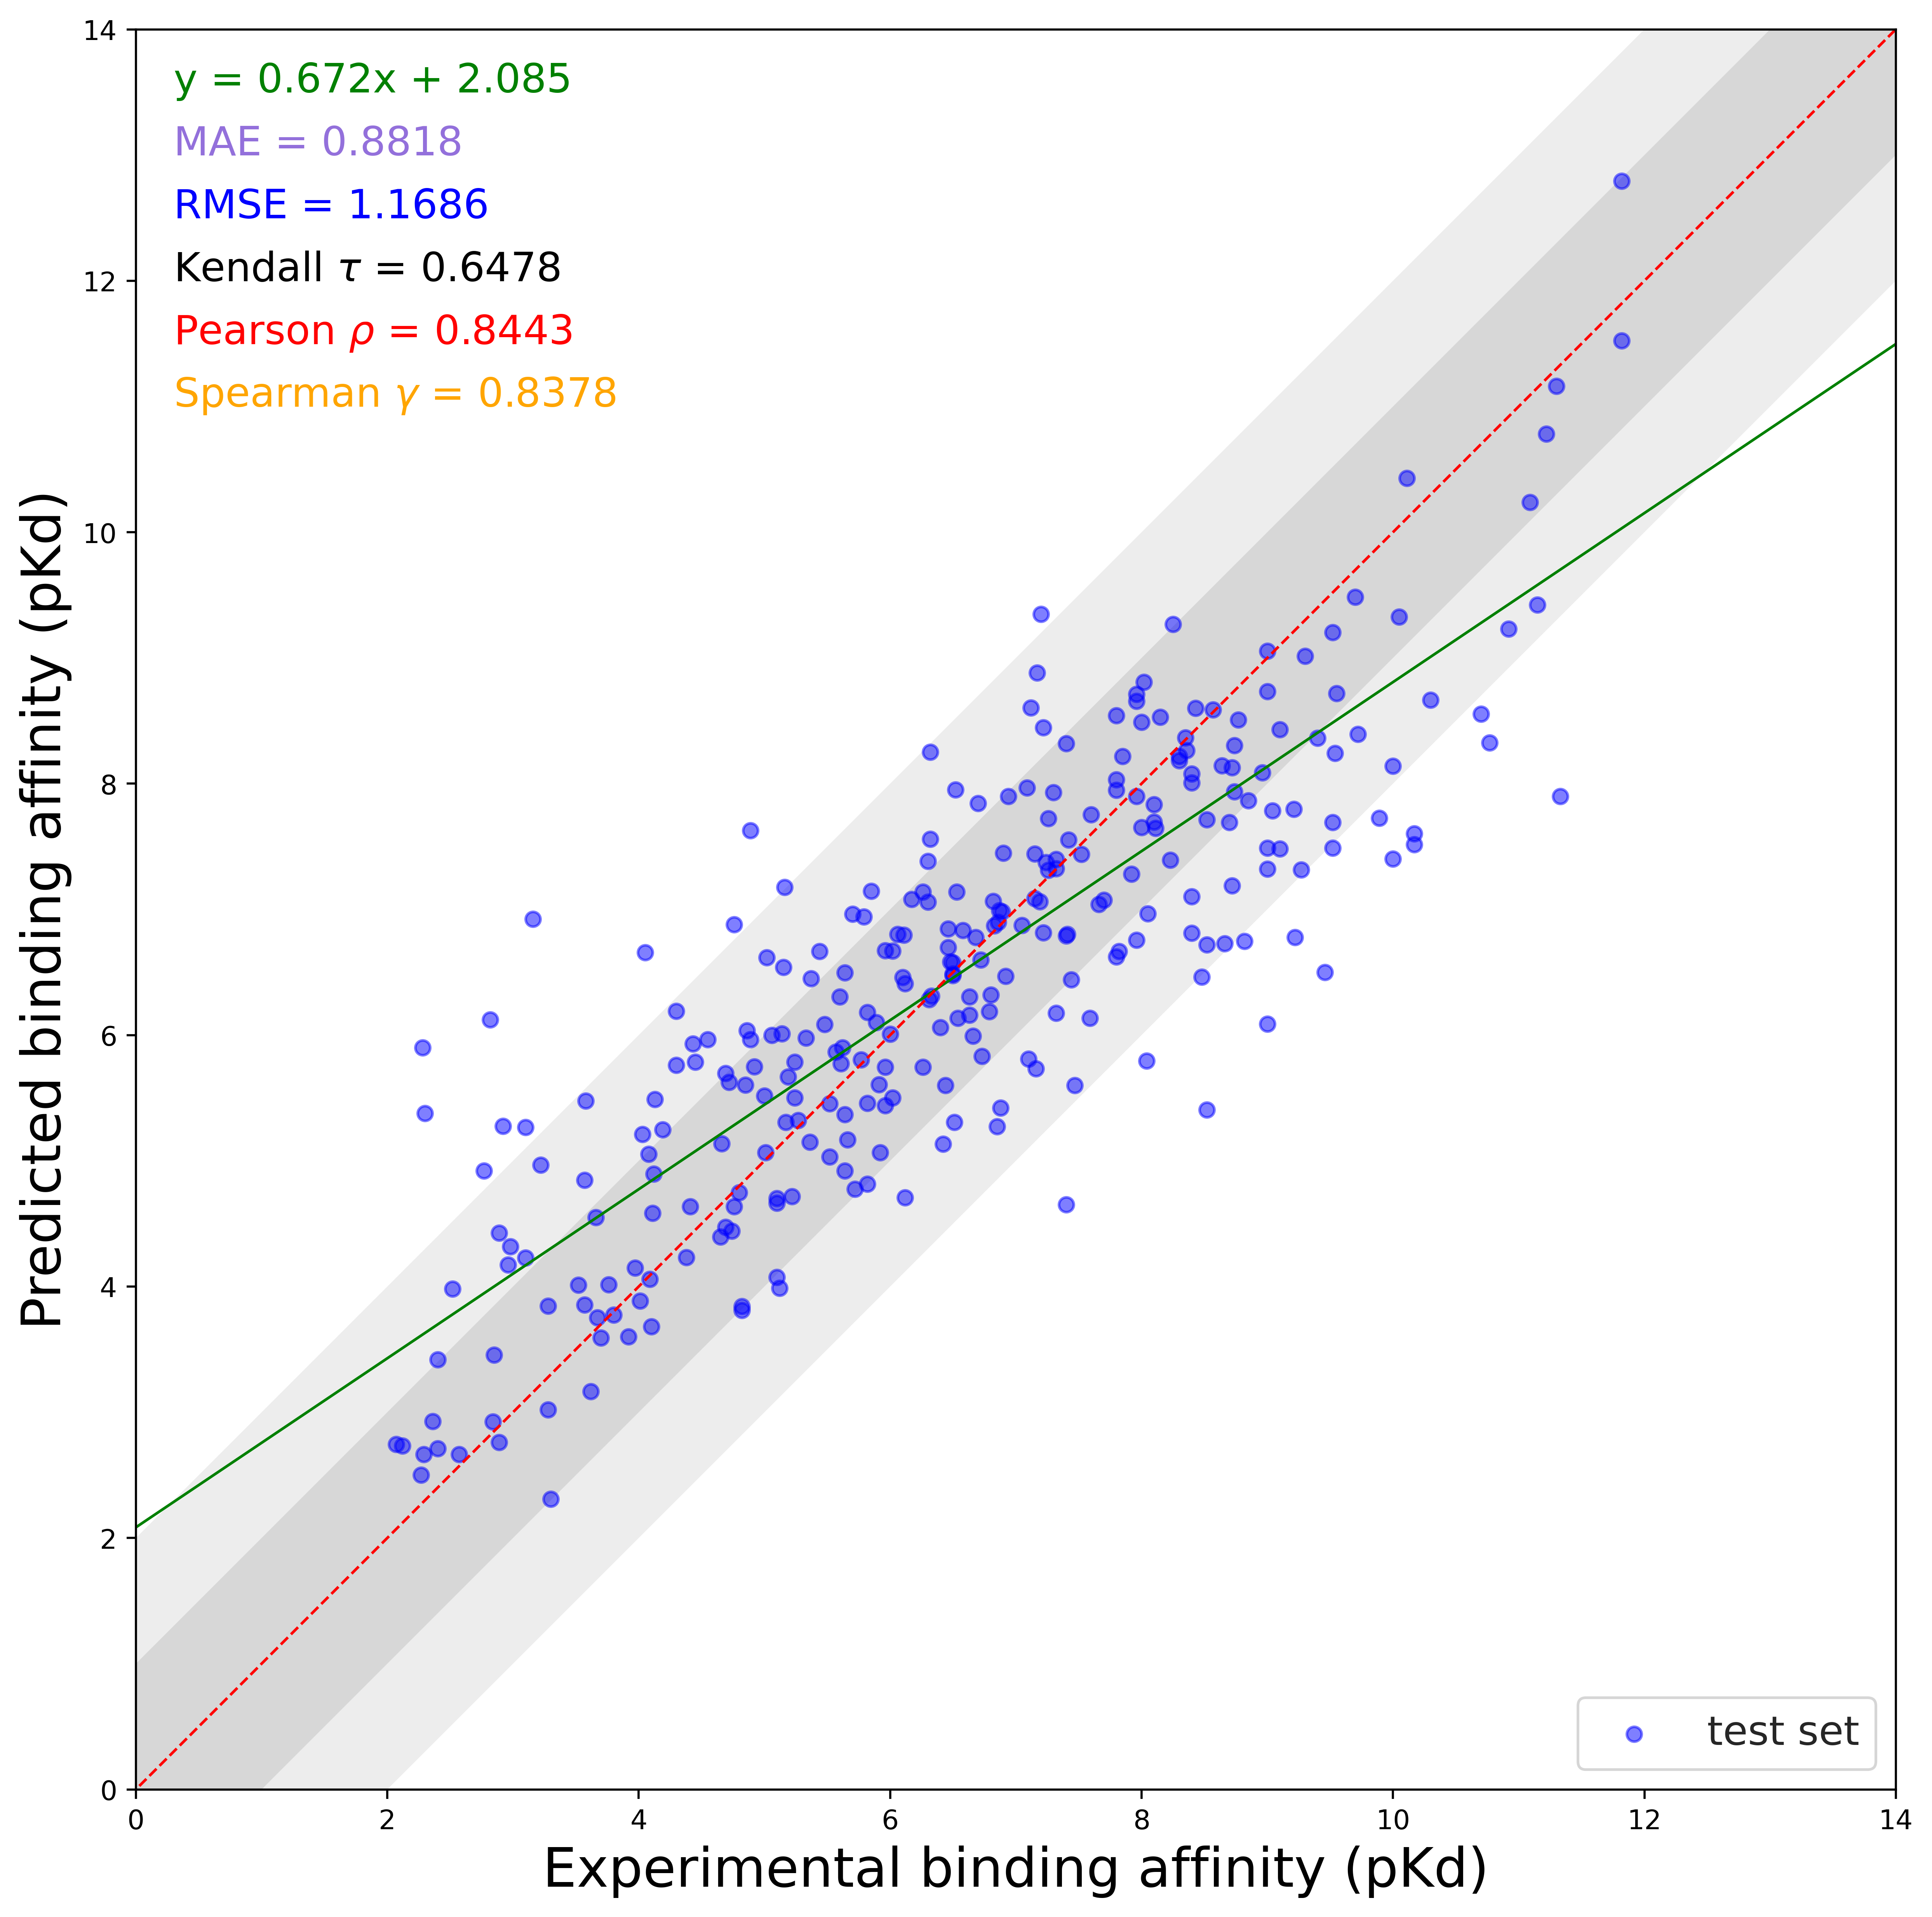

In [12]:
draw_scatter( true, pkd, test=True )

In [123]:
# draw_scatter( train_true, train_pkd, test=False )